In [30]:
import numpy as np
import pandas as pd

# Charger les données du fichier texte en ignorant les 44 premières lignes
file_path = 'D:/Documents/Mémoire/Data John Doe/John Doe gaitway 3D locomotion_W3.txt'
data = pd.read_csv(file_path, skiprows=44, delimiter='\t')

# Extraire les colonnes temps et signal
time = data.iloc[:, 0].values
signal = data.iloc[:, 19].values

# Appliquer une moyenne mobile (window=21, center=True)
signal_series = pd.Series(signal)
moving_average = signal_series.rolling(window=51, center=True).mean().values

# Définir les seuils avant et après la ligne 8500
thresholds = {
    "before_8500": {"peak": 1.935, "valley": 1.9235},
    "after_8500": {"peak": 1.9425, "valley": 1.929}
}

# Détection des pics et des vallées
peaks = []
valleys = []
window_size = 50
curve_size = 120

for i in range(len(moving_average) - window_size):
    window = moving_average[i:i + window_size]
    time_window = time[i:i + window_size]

    # Déterminer les seuils en fonction de la ligne actuelle
    if i < 8500:
        peak_threshold = thresholds["before_8500"]["peak"]
        valley_threshold = thresholds["before_8500"]["valley"]
    else:
        peak_threshold = thresholds["after_8500"]["peak"]
        valley_threshold = thresholds["after_8500"]["valley"]

    # Détecter les pics et les vallées dans la fenêtre (nan ignorés)
    max_val = np.nanmax(window)
    window_min_val = np.nanmin(window)
    max_index = np.nanargmax(window)
    window_min_index = np.nanargmin(window)

    # Vérifier les conditions de pics et vallées (pic>seuil and vallée<seuil and pic_avant_vallée and fenêtré)
    if (max_val >= peak_threshold and window_min_val <= valley_threshold and
            max_index < window_min_index and window_min_index - max_index < 150 and
            max_val - window_min_val > 0.0125):
        peaks.append((time_window[max_index], max_val))
        
        # create a sub-window from the max_index to the curve_size, in absolute position
        curve_window = moving_average[i+max_index:i+max_index + curve_size]
        min_val = np.nanmin(curve_window)
        min_index = np.nanargmin(curve_window) + i+max_index
        
        valleys.append((time[min_index], min_val))

# Créer un DataFrame pour les pics et les vallées
peaks_df = pd.DataFrame(peaks, columns=['Time', 'Value'])
valleys_df = pd.DataFrame(valleys, columns=['Time', 'Value'])

# Calculer la différence de temps entre les pics/vallées consécutifs
peaks_df['Time_Diff'] = peaks_df['Time'].diff()
valleys_df['Time_Diff'] = valleys_df['Time'].diff()

# Filtrer les DataFrames pour ne conserver que les lignes où la différence de temps est supérieure à 0.3
peaks_df = peaks_df[peaks_df['Time_Diff'] > 0.3]
valleys_df = valleys_df[valleys_df['Time_Diff'] > 0.3]

# Ajouter le nombre de pics et vallées trouvés
peaks_count = len(peaks_df)
valleys_count = len(valleys_df)

# Créer un fichier Excel et ajouter les données
with pd.ExcelWriter('detected_patterns_W7.xlsx') as writer:
    peaks_df.to_excel(writer, sheet_name='Peaks', index=False)
    valleys_df.to_excel(writer, sheet_name='Valleys', index=False)

print(f'Nombre de pics : {peaks_count}')
print(f'Nombre de vallées : {valleys_count}')
print("Detection complète, résultats sauvegardés dans detected_patterns.xlsx")




Nombre de pics : 0
Nombre de vallées : 0
Detection complète, résultats sauvegardés dans detected_patterns.xlsx


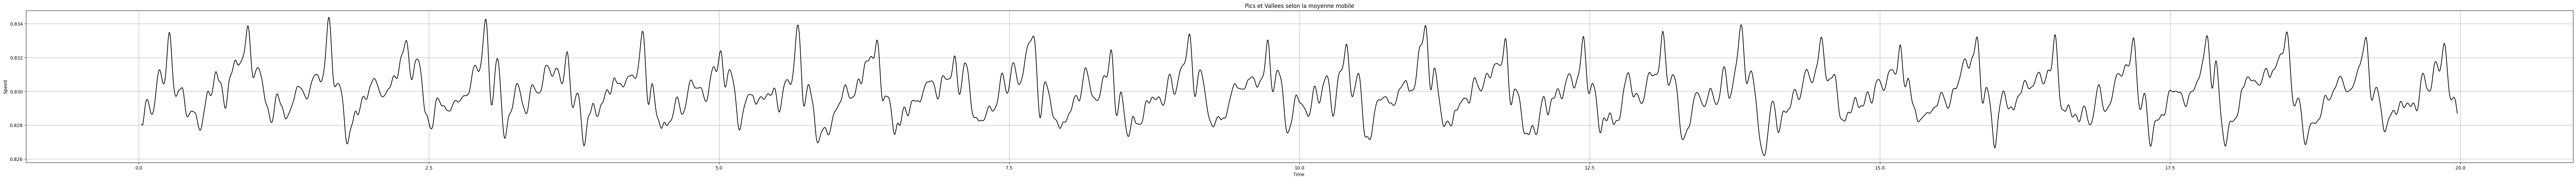

In [31]:
import matplotlib.pyplot as plt

# averages_vals = []
# averages_vals.append((time[i], moving_average[i], ''))
# averages_vals_df = pd.DataFrame(averages_vals)

plt.figure(figsize=(100, 6))

plt.plot(time, moving_average, color='black', label='Moving Average')
plt.scatter(valleys_df['Time'], valleys_df['Value'],  color='green', label='vallees')
plt.scatter(peaks_df['Time'], peaks_df['Value'],  color='blue', label='pics')

plt.xlabel('Time ')
plt.ylabel('Speed')
plt.title('Pics et Vallees selon la moyenne mobile')
plt.grid(True)
plt.show()


In [32]:
# contact_mode = data[31]
contact_mode = data.iloc[:, 31].values
lift_down = []
lift_off = []

previous_mode = None
for i in range(len(contact_mode)):
    if pd.notna(contact_mode[i]):
        current_mode = contact_mode[i]
        if (previous_mode is None or previous_mode != 'SC') and current_mode == 'SC':
            lift_down.append((time[i], 'Simple appui'))
        previous_mode = current_mode
        
previous_mode = None
for i in range(len(contact_mode)):
    if pd.notna(contact_mode[i]):
        current_mode = contact_mode[i]
        if (previous_mode is None or previous_mode != 'DC') and current_mode == 'DC':
            lift_off.append((time[i], 'Double appui'))
        previous_mode = current_mode

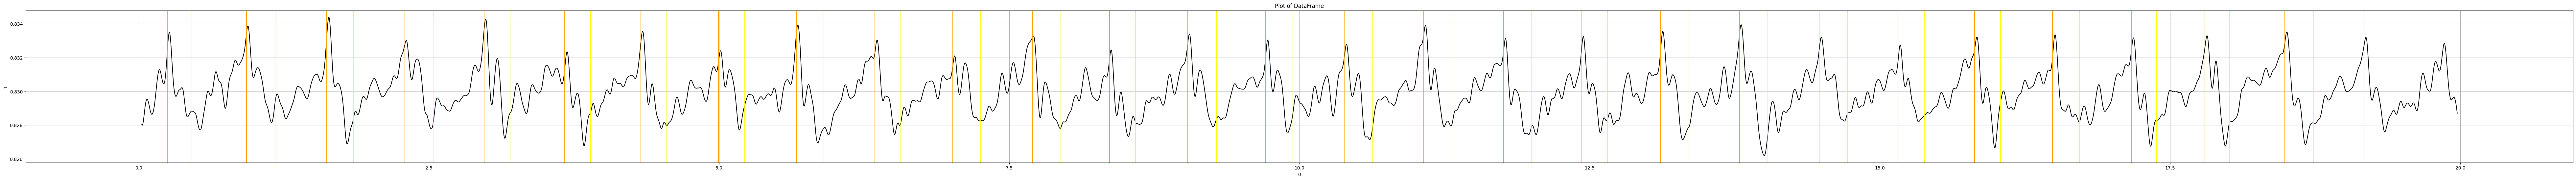

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(100, 6))
peaks_df = pd.DataFrame(peaks, columns=['Time', 'Value'])
valleys_df = pd.DataFrame(valleys, columns=['Time', 'Value'])
# moving_average_df = pd.DataFrame(moving_average)
lift_off_df = pd.DataFrame(lift_off)
lift_down_df = pd.DataFrame(lift_down)

plt.plot(time, moving_average, color="black")

plt.scatter(x=valleys_df['Time'], y=valleys_df['Value'],  color='green', label='vallees' if i == 0 else "")
plt.scatter(x=peaks_df['Time'], y=peaks_df['Value'],  color='blue', label='pics' if i == 0 else "")

# for i in range(len(valleys_df)):
#     plt.axvline(x=valleys_df[0][i], color='green', label='vallees' if i == 0 else "")

# for i in range(len(peaks_df)):
#     plt.axvline(x=peaks_df[0][i], color='blue', label='pics' if i == 0 else "")

for i in range(len(lift_down_df)):
    plt.axvline(x=lift_down_df[0][i], color='yellow', label='Pose de pas' if i == 0 else "")
    
for i in range(len(lift_off_df)):
    plt.axvline(x=lift_off_df[0][i], color='orange', label='Levé de pas' if i == 0 else "")


plt.xlabel('0')
plt.ylabel('1')
plt.title('Plot of DataFrame')
plt.grid(True)
plt.show()

In [34]:
peaks_df

,Time,Value
